# An introduction to Shap Values and Partial Dependence Plots with Businesss Use Cases in the CPG Industry 

## Motivation

While accurate predictions are an important part of business strategy, in predictions are often useless without a means influencing the outcome. Suppose we have a model which predicts whether a shipment from a manufacturer to a retailer, will arrive on time. If our model only predicts the shipment will be late but doesn't also inform us which factors are contributing to that prediction, then it isn't helpful in preventing the shipment from being late and assoicated losses. The CPG industry (Consumer Packaged Goods) is the industry of manufacturing low cost and fast selling products such as soft drinks, tooth paste, candies, over-the-counter drugs, etc. Timing is paramount in the CPG industry, hence it is crucial to know which features can be leveraged to increase the number of on-time deliveries.

The good news is that in predictive modeling there are ways to meausre the contribution of each feature to a given prediction, so action can be taken to affect the outcome. Techniques which leverage importance of features for predicions are called "feature importance" or "inference" techniques in the machine learning and statistics literature, respectively. In this article, we discuss two well known methods for feature importance, how they are calculated, how to apply them, as well as the pros and cons of each. While the discussion is focused on applications to the CPG Industry we will be mathematically rigourous.

## Partial Dependence Plots (PDPs)

### Example

Suppose we are a manufacturer who is predicting how much revenue can be expected from a retailer based on two features: Discount $(D)$ and Size $(S)$. Here $D$ refers to any discount given to the retailer, and $S$ indicates the size of the retailer such as number of stores, number of employees, etc. Furthermore suppose a simple linear model was fitted for the revenue $R$ based on these two features yielding $R=D+2S+1$. Assuming that the data was transformed to be on the same scale prior to the fit, we can interpret this to mean that the size of the manufacturer is twice as important as whether or not they got a discount. Linear models have the advantage that this interpretation is clear provided the features are independent. Consider now a more general model of the form $R=f(D,S)$ where $f$ is some (nonlinear) function of discount and size. We can use partial dependence plots to gain an insight similar to the above provided that $D$ and $S$ are independent.

Definition. The partial dependence of $R$ on $D$ is given by $PD_R(D)=E_S(f(D,S))$ where $S$ is thought of as random, $R$ as fixed, and $E_S$ denotes expected value with respect to $S$.   

Remark. For the linear example above we have $PD_R(D)=E_S(D+2S+1)=D+2E(S)+1$, which is a linear function of $D$, with slope 1. This is clearly not informative since the model is already linear, but nonetheless is consistent with what we would expect. If we assume that $S$ and $D$ are independent and drawn from a Normal distribution $\mathcal{N}(1,0.25)$ this becomes $PD_R(D)=E_S(D+2S+1)=D+3$ and similarly $PD_R(S)=2S+E(D)+1=2S+2$ 

We can verify these relationships by plotting the partial dependence functions below.

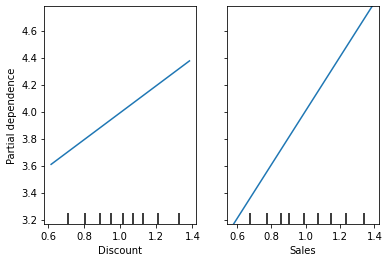

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.inspection import plot_partial_dependence

X = np.random.normal(1, 0.25, (200,2))
    
d = X[:,0]

s = X[:,1]


r=d+2*s+1

reg = LinearRegression().fit(X, r)

plot_partial_dependence(reg, X, features=[0,1], feature_names=['Discount', 'Sales'])



E.g. if $R=D^4+2S^2+1$ so that the relationship is no longer linear then neither are the PDPs:

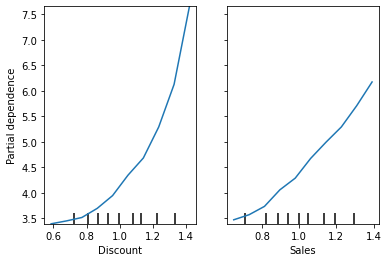

In [2]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import RandomForestRegressor


X = np.random.normal(1, 0.25, (200,2))
    
d = X[:,0]

s = X[:,1]



r=d**4+2*(s**2)+1

reg = RandomForestRegressor().fit(X, r)

plot_partial_dependence(reg, X, features=[0,1], feature_names=['Discount', 'Sales'], grid_resolution=10)



Problems begin to emerge when collinear terms appear. E.g. $R=D^2+S+1$ where $S=D$.

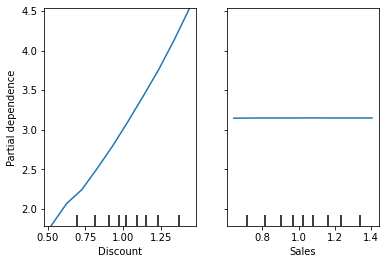

In [3]:
X = np.random.normal(1, 0.25, (200,2))
    
d = X[:,0]

s = X[:,1]

r=d**2+d+1

reg = RandomForestRegressor().fit(X, r)

plot_partial_dependence(reg, X, features=[0,1], feature_names=['Discount', 'Sales'], grid_resolution=10)



Hence when using partial dependence plots one should exercise caution with multicollinearity. In this example it would appear that increasing sales has no effect on revenue! A good way to test for multicollinearity when performing any kind of regression is to refit the model on different random samples to see how much the regression coefficients vary each time. Alternatively, if the regression assumes a data generating mechanism (E.g. classical linear regression), then one can examine the p-values and confidence intervals for the coefficients.

So far we have limited the discussion to examining the partial dependence of one covariate at a time. We can also examine the PDP of two or more covariates. E.g. consider $R=D^2+S+7N+1$ where we added an additional feature $N$ to denote the number of employees we have that $$PD_R(D,S)=E_N(D^2+S+7N+1)=D^2+S+7E(N)+1.$$

Assuming all of the features are independent and drawn from a normal distribution $\mathcal{N}(1,0.25)$, we have that $PD_R(D,S)=D^2+S+8$. We simulate this and plot a countour map where the numbers indicate the direction of increasing revenue.

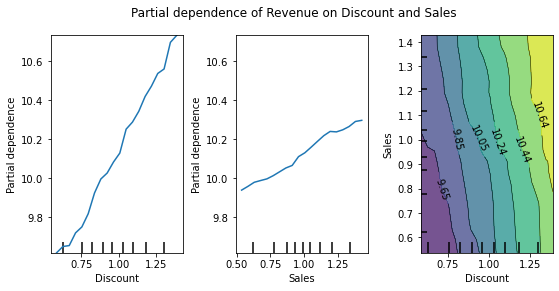

In [4]:
from sklearn.inspection import partial_dependence


X = np.random.normal(1, 0.25, (200,3))
    
d = X[:,0]

s = X[:,1]

n = X[:,2]

 

r=d**2+s+7*n+1

reg = RandomForestRegressor().fit(X, r)

#plot_partial_dependence(reg, X, features=[0,1,2], feature_names=['Discount', 'Sales', 'No. Employees'], grid_resolution=10)

features = [0,1, (0,1)]

_, ax = plt.subplots(ncols=3, figsize=(9, 4))
display = plot_partial_dependence(reg, X, features, feature_names=['Discount', 'Sales', 'No. Employees'], n_jobs=3, grid_resolution=20,ax=ax)

display.figure_.suptitle(
'Partial dependence of Revenue on Discount and Sales')
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

This way the problem of multicollinearity can be circumvented if the collinear terms are grouped together in the contor plot. An obvious con is that we may not a priori know which terms are correlated and in addition, the above plots become infeasible to visualize when the numer of indpendent features is more than three. 

All of the above examples came from regerssion where we had an explicit formula for the dependence of revenue on the features, and hence the need for partial dependence plots is not clear. However, these plots are very useful when the model is not merely a regression and is non-parametric such as a tree based model, a neural network, or any kind of ensemble. Furthermore, despite the fact that tree based models give feature importances, these are different from partial dependence and do not indicate whether the target (in our case revenue), increases or decreases when the feature is increased or decreased. 

## Shap Values

While PDPs give a good aggregated view of how one feature impacts the target, often times we want to know the contribution of each feature to the target at a specific data sample. 

E.g. Suppose we are predicting revenue based on sales and discount, and our model tells us that when sales is 6000 USD and the discount is 1000 USD, revenue will be 10000 USD. If we are using e.g. a tree based regression model, and we would like to know the exact contribution of each feature to this prediction then we cannot rely on PDPs, since by definition they only tell us the expected revenue when aggregated over the complementary features.

This is where Shap values are useful, as they provide an answer to this question.

## Idea

Consider again for illustration the linear model from above $R=D+2S+1$. We wish to compute the Shap values. Each feature has a Shap value. Since Shap values tell us the contribution of each feature for a given prediction, they themselves depend on the features and are computed the following way.

$$\underbrace{\varphi_S(s,d)}_{\mbox{Shap value for sales}}=\underbrace{\frac{1}{2}\big (R(s,0)-R(0,0) \big)}_{\mbox{sales vs. baseline}}+\underbrace{\frac{1}{2}\big(R(s,d)-R(0,d) \big)}_{\mbox{sales vs. discount}}$$

By baseline we mean the prediction of revenue when all features are set to zero, i.e. $R(0,0)=1$. Similarly,

$$\underbrace{\varphi_D(s,d)}_{\mbox{Shap value for discount}}=\underbrace{\frac{1}{2}\big (R(0,d)-R(0,0) \big)}_{\mbox{discount vs. baseline}}+\underbrace{\frac{1}{2}\big(R(s,d)-R(s,0) \big)}_{\mbox{discount vs. sales}}$$

Notice that 

$$R(s,d)=\varphi_S(s,d)+\varphi_D(s,d)+\underbrace{R(0,0)}_{\mbox{baseline}}$$

which justifies how Shap values give individual feature contribution for a given prediction (igonoring the baseline).

As can be seen above, the Shap values simply compare the effect of removing the feature under consideration from the prediction averaged over all combinations. In this example, $\varphi_D(s,d)=d$ and $\varphi_S(s,d)=2s$, which is not informative because we are dealing with a simple linear model, but this calculation can (in theory) be applied to any supervised learning problem! 

To compute Shap values for a general supervised learning problem, one would need to perform a huge number of summations which quickly becomes infeasible. Fortunately, there are tricks for estimation of Shap values which exploit the particular model structure in question.


$\textbf{Warning:}$ While the above calculation captures the main idea of computing Shap values, there are different ways of defining a "baseline" and what it means to "exclude features". E.g. instead of taking $R(0,0)$ as a baseline we could have taken the mean target prediction, and instead of using $R(s,0)$ and $R(0,d)$ to mean "excluding" discount and sales, respectively, we could have aggregated over the excluded independent variable. This leads to a variety of interpretations for Shap values depending on the nature of the implementation! However all implementations will have the property that the sum of Shap values with the baseline adds up to the prediction.

Next we use the Python library SHAP to give some examples. E.g. let's start with the linear model above 

$$R=D+2S+1.$$

We will fit a random forest regression to data generated by the above formula by drawing samples from a $\mathcal{N}(1,0.25)$ distribution for both discount and sales. We choose a tree based algorithm since SHAP has efficient implementations for these.

In [5]:
import pandas as pd
import shap

X = np.random.normal(1, 0.25, (200,2))
    
d = X[:,0]

s = X[:,1]


X = pd.DataFrame({'Discount':d, 'Sales':s})



r=d+2*s+1

reg = RandomForestRegressor().fit(X, r)

shap.initjs()



model = reg


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)


shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])



The above has the following interpretation: The particular observation is $D=1.072$ and $S=0.709$. The baseline here is computed as an average over the predicted target, hence is approximately 4, since $E_{S,D}(R)=4$ because we assumed $S,D$ are drawn from a Normal distribution with mean 1. The prediction outputted corresponding to this particular choisce of $(D,S)$ is 3.46. Furthermore, discount is increasing the revenue indicated in red, whereas sales is lowering it (in blue). This may seem puzzling, but it is a consequence of the difference in implementing the calculation of Shap values discussed above. 

We can use the SHAP library to compute Shap values pointwise across different feature values $(S,D)$:

In [6]:
shap.force_plot(explainer.expected_value, shap_values, X)

Taking the mean absolute value of the Shap values for each feature and plotting this in a bar plot gives us:

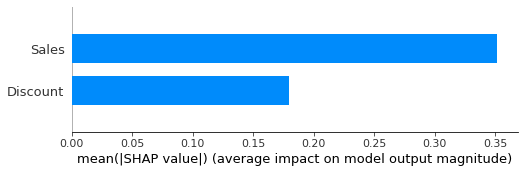

In [7]:
shap.summary_plot(shap_values, X, plot_type="bar")

The aggregated absolute value of Shap values above is consistent with the interpretation from the linear models. 

Hence although Shap values are a convenient way to "explain" any prediction to a stakeholder, one should exercise caution since depening on implementation Shap values can differ drastically for a given prediction, independenlty of multicollinearity.

## CPG Industry Case Study